# Lysostaphin vs Staphylococcus aureus

AF3 modelling of lysostaphin (catalytic and cell wall binding domain) in complex with peptidoglycan fragments from S. aureus.

PG library generated with [PGN_MS2](https://github.com/jerickwan/PGN_MS2).

In [1]:
from copy import deepcopy
import json
import os
from pathlib import Path
import random
import re
import subprocess
import tempfile

import numpy as np
import pandas as pd
from Bio import SeqIO
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from IPython.display import display

cwd = os.getcwd()
if cwd.endswith('notebook/PG'):
    os.chdir('../..')
    cwd = os.getcwd()

from src.pg_modelling.ligand_utils import generate_ccd_from_smiles, sanitize_ligand_name, generate_conformation

In [2]:
data_folder = Path(os.path.expanduser('~')) / 'Documents' / 'PG_modelling'
assert data_folder.is_dir()

## Generate possible bridges

In [3]:
canonical = 'Gly>Gly>Gly>Gly>Gly'  # pentaglycine
smaller_bridges = [
    'Gly>Gly>Gly>Gly',
    'Gly>Gly>Gly',
    'Gly>Gly',
    'Gly',
]
ala_bridges = [
    'Ala>Gly>Gly>Gly>Gly',
    'Gly>Ala>Gly>Gly>Gly',
    'Gly>Gly>Ala>Gly>Gly',
    'Gly>Gly>Gly>Ala>Gly',
    'Gly>Gly>Gly>Gly>Ala',
]
ser_bridges = [
    'Ser>Gly>Gly>Gly>Gly',
    'Gly>Ser>Gly>Gly>Gly',
    'Gly>Gly>Ser>Gly>Gly',
    'Gly>Gly>Gly>Ser>Gly',
    'Gly>Gly>Gly>Gly>Ser',
]
','.join([canonical] + smaller_bridges + ala_bridges + ser_bridges)

'Gly>Gly>Gly>Gly>Gly,Gly>Gly>Gly>Gly,Gly>Gly>Gly,Gly>Gly,Gly,Ala>Gly>Gly>Gly>Gly,Gly>Ala>Gly>Gly>Gly,Gly>Gly>Ala>Gly>Gly,Gly>Gly>Gly>Ala>Gly,Gly>Gly>Gly>Gly>Ala,Ser>Gly>Gly>Gly>Gly,Gly>Ser>Gly>Gly>Gly,Gly>Gly>Ser>Gly>Gly,Gly>Gly>Gly>Ser>Gly,Gly>Gly>Gly>Gly>Ser'

## Load Lysostaphin

In [4]:
lysostaphin_path = data_folder / 'S_aureus' / 'S_aureus_lysostaphin.fasta'
lysostaphin_records = SeqIO.to_dict(SeqIO.parse(lysostaphin_path, 'fasta'))

In [5]:
lysostaphin_peptidase_m23 = {
    'protein': {
        'id': 'A',
        'sequence': str(lysostaphin_records['Lysostaphin_P10547_Peptiase_M23_279_364'].seq).upper()
    },
}
lysostaphin_sh3b = {
    'protein': {
        'id': 'A',
        'sequence': str(lysostaphin_records['Lysostaphin_P10547_SH3b_413_481'].seq).upper()
    },
}

## Load PG fragments

In [6]:
pgn_df = pd.read_csv(data_folder / 'S_aureus' / 'S_aureus_fragments_1mer.csv')
print(f'Number of fragments: {len(pgn_df):,}')
pgn_df.head()

Number of fragments: 195


,Name,Synonym,Formula,Monoisotopic Mass,Modifications,Degree Amidation,Degree Acetylation,Ontology,PGN Units,Glycan Units,...,Peptide,SMILES,INCHIKEY,clogP,RT,[M+H]+,[M+Na]+,[M+K]+,[M+2H]2+,[M+3H]3+
0,None-K[3-NH2-GGGGA],None--Lys[3--NH2--Gly.Gly.Gly.Gly.Ala],C17H31N7O7,445.22850,EPase P2,0,0,P3--S5,1,0,...,K[3-NH2-GGGGA],CC(N)C(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCCCCC(N...,SZYLKPZPDXMNKU-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678
1,None-AqK[3-NH2-GGGGA],None--Ala.γ-isoGln.Lys[3--NH2--Gly.Gly.Gly.Gly...,C25H44N10O10,644.32419,Amidase,1,0,P3--S5,1,0,...,AqK[3-NH2-GGGGA],CC(N)C(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCCCCC(N...,RBKYMGGPVJWHMK-UHFFFAOYSA-N,-6.2482,0,645.33147,667.31341,683.28735,323.16938,215.78201
2,None-K[3-NH2-GGGAG],None--Lys[3--NH2--Gly.Gly.Gly.Ala.Gly],C17H31N7O7,445.22850,EPase P2,0,0,P3--S5,1,0,...,K[3-NH2-GGGAG],CC(NC(=O)CN)C(=O)NCC(=O)NCC(=O)NCC(=O)NCCCCC(N...,SOOQFNIYIPGCLP-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678
3,None-K[3-NH2-GGAGG],None--Lys[3--NH2--Gly.Gly.Ala.Gly.Gly],C17H31N7O7,445.22850,EPase P2,0,0,P3--S5,1,0,...,K[3-NH2-GGAGG],CC(NC(=O)CNC(=O)CN)C(=O)NCC(=O)NCC(=O)NCCCCC(N...,QTPFCZZQBOJGEK-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678
4,None-K[3-NH2-GAGGG],None--Lys[3--NH2--Gly.Ala.Gly.Gly.Gly],C17H31N7O7,445.22850,EPase P2,0,0,P3--S5,1,0,...,K[3-NH2-GAGGG],CC(NC(=O)CNC(=O)CNC(=O)CN)C(=O)NCC(=O)NCCCCC(N...,TVCZZGTWYXQCDJ-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678


Sub-select entries without glycans but with stem + bridge, or stem alone or bridge alone (including Lys residue from stem).

In [7]:
pgn_subset_raw = pgn_df[
    (pgn_df['Glycan Units'] == 0) &
    (
        pgn_df['Peptide Units'].isin([4, 5]) &
        (pgn_df['Modifications'] == 'Amidase')
    ) |
    (
        pgn_df['Peptide Units'].isin([3, 4]) &
        (pgn_df['Modifications'] == 'EPase P2')
    )
].reset_index(drop=True)
pgn_subset_raw['ligand_name'] = pgn_subset_raw['Name'].apply(lambda n: sanitize_ligand_name(n))
print(f'Number of fragments in subset: {len(pgn_subset_raw):,}')
pgn_subset_raw.head()

Number of fragments in subset: 61


,Name,Synonym,Formula,Monoisotopic Mass,Modifications,Degree Amidation,Degree Acetylation,Ontology,PGN Units,Glycan Units,...,SMILES,INCHIKEY,clogP,RT,[M+H]+,[M+Na]+,[M+K]+,[M+2H]2+,[M+3H]3+,ligand_name
0,None-K[3-NH2-GGGGA],None--Lys[3--NH2--Gly.Gly.Gly.Gly.Ala],C17H31N7O7,445.2285,EPase P2,0,0,P3--S5,1,0,...,CC(N)C(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCCCCC(N...,SZYLKPZPDXMNKU-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678,K-3-NH2-GGGGA
1,None-K[3-NH2-GGGAG],None--Lys[3--NH2--Gly.Gly.Gly.Ala.Gly],C17H31N7O7,445.2285,EPase P2,0,0,P3--S5,1,0,...,CC(NC(=O)CN)C(=O)NCC(=O)NCC(=O)NCC(=O)NCCCCC(N...,SOOQFNIYIPGCLP-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678,K-3-NH2-GGGAG
2,None-K[3-NH2-GGAGG],None--Lys[3--NH2--Gly.Gly.Ala.Gly.Gly],C17H31N7O7,445.2285,EPase P2,0,0,P3--S5,1,0,...,CC(NC(=O)CNC(=O)CN)C(=O)NCC(=O)NCC(=O)NCCCCC(N...,QTPFCZZQBOJGEK-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678,K-3-NH2-GGAGG
3,None-K[3-NH2-GAGGG],None--Lys[3--NH2--Gly.Ala.Gly.Gly.Gly],C17H31N7O7,445.2285,EPase P2,0,0,P3--S5,1,0,...,CC(NC(=O)CNC(=O)CNC(=O)CN)C(=O)NCC(=O)NCCCCC(N...,TVCZZGTWYXQCDJ-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678,K-3-NH2-GAGGG
4,None-K[3-NH2-AGGGG],None--Lys[3--NH2--Ala.Gly.Gly.Gly.Gly],C17H31N7O7,445.2285,EPase P2,0,0,P3--S5,1,0,...,CC(NC(=O)CNC(=O)CNC(=O)CNC(=O)CN)C(=O)NCCCCC(N...,QZVBVXIUIJHCOE-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678,K-3-NH2-AGGGG


## Cleaving peptide bridge from sidechain

CC(N)C(=O)NC(CCC(=O)NC(CCCCNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CN)C(=O)NC(C)C(=O)O)C(N)=O


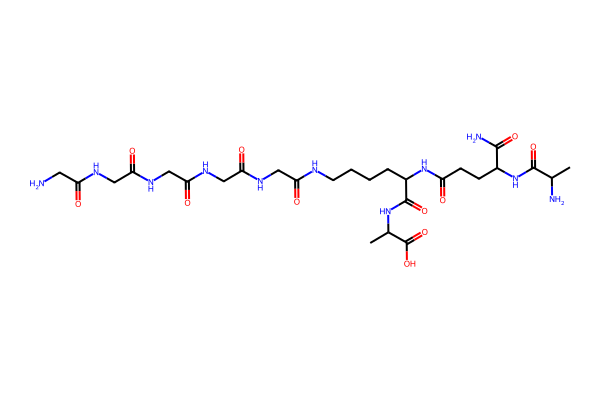

In [8]:
smiles = pgn_subset_raw[pgn_subset_raw['Name'] == 'None-AqKA[3-NH2-GGGGG]'].iloc[0]['SMILES']

print(smiles)

mol = Chem.MolFromSmiles(smiles)

img = Chem.Draw.MolToImage(mol, size=(600, 400), dpi=300)
display(img)

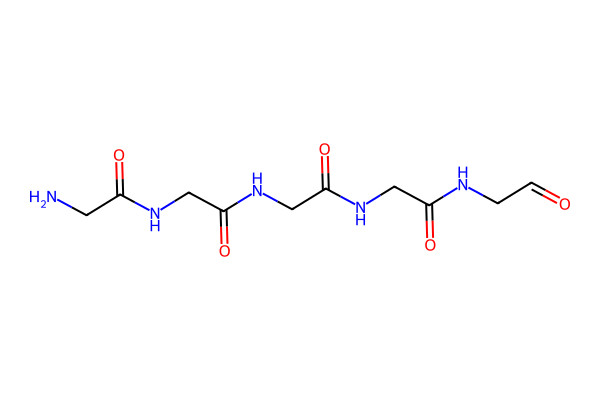

In [9]:
rxn_smarts = """
[CH2][CH2][CH2][CH2][N;X3:1]-[C;X3:2](=O)-[*:3] >>
[CH2][CH2][CH2][CH2][N;X3:1].[C;X3:2](=O)-[*:3]
"""
rxn = AllChem.ReactionFromSmarts(rxn_smarts)

def cleave_lys_amide(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    products_sets = rxn.RunReactants((mol,))
    if len(products_sets) == 0:
        return None
    
    assert len(products_sets) == 1, len(products_sets)
    
    return products_sets[0][1]


res_mol = cleave_lys_amide(smiles)

img = Chem.Draw.MolToImage(res_mol, size=(600, 400), dpi=300)
display(img)

Add bridges to CSV file.

In [10]:
seen_ligands = {tpl.SMILES for tpl in pgn_subset_raw.itertuples()}
bridges_data = []
for _, row in pgn_subset_raw[pgn_subset_raw['Name'].str.contains('[3-NH2-', regex=False)].iterrows():
    bridge = cleave_lys_amide(row['SMILES'])
    if bridge is None:
        continue

    Chem.SanitizeMol(bridge)

    bridge_smiles = Chem.MolToSmiles(bridge)

    if bridge_smiles is not None and bridge_smiles not in seen_ligands:
        seen_ligands.add(bridge_smiles)
    else:
        continue

    bridge_name = re.match(r'^.+\[3-NH2-([^\[\]]+)\]$', row['Name'])[1]

    print(row['Name'], bridge_name)

    bridge_data = {
        'Name': bridge_name, 
        'Synonym': None, 
        'Formula': Chem.rdMolDescriptors.CalcMolFormula(bridge), 
        'Monoisotopic Mass': np.round(Descriptors.ExactMolWt(bridge), 5), 
        'Modifications': 'Bridge only',
        'Degree Amidation': 0, 
        'Degree Acetylation': 0, 
        'Ontology': None, 
        'PGN Units': 1,
        'Glycan Units': 0, 
        'Peptide Length': 0, 
        'Peptide Units': 0, 
        'Polymerised Unit': None,
        'Polymerisation Type': None, 
        'Glycan': None, 
        'Peptide': bridge_name, 
        'SMILES': bridge_smiles, 
        'INCHIKEY': Chem.inchi.MolToInchiKey(bridge),
        'clogP': None, 
        'RT': None, 
        '[M+H]+': None, 
        '[M+Na]+': None, 
        '[M+K]+': None, 
        '[M+2H]2+': None, 
        '[M+3H]3+': None,
        'ligand_name': bridge_name,
    }
    bridges_data.append(bridge_data)

pgn_subset = pd.concat(
    [
        pgn_subset_raw,
        pd.DataFrame(bridges_data),
    ],
    ignore_index=True,
)

print(f'Number of fragments in subset: {len(pgn_subset):,}')
pgn_subset.to_csv(data_folder / 'S_aureus' / 'S_aureus_pg_subset.csv', index=False)

pgn_subset.tail()

None-K[3-NH2-GGGGA] GGGGA
None-K[3-NH2-GGGAG] GGGAG
None-K[3-NH2-GGAGG] GGAGG
None-K[3-NH2-GAGGG] GAGGG
None-K[3-NH2-AGGGG] AGGGG
None-K[3-NH2-GGGGS] GGGGS
None-K[3-NH2-GGGSG] GGGSG
None-K[3-NH2-GGSGG] GGSGG
None-K[3-NH2-GSGGG] GSGGG
None-K[3-NH2-SGGGG] SGGGG
None-K[3-NH2-GGGGG] GGGGG
None-K[3-NH2-GGGG] GGGG
None-K[3-NH2-GGG] GGG
None-K[3-NH2-GG] GG
None-KA[3-NH2-G] G
Number of fragments in subset: 76


/var/folders/xd/714yy8tn5vz90_wtnn7vglhc0000gq/T/ipykernel_27739/1160724495.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pgn_subset = pd.concat(


,Name,Synonym,Formula,Monoisotopic Mass,Modifications,Degree Amidation,Degree Acetylation,Ontology,PGN Units,Glycan Units,...,SMILES,INCHIKEY,clogP,RT,[M+H]+,[M+Na]+,[M+K]+,[M+2H]2+,[M+3H]3+,ligand_name
71,GGGGG,None,C10H17N5O5,287.12297,Bridge only,0,0,None,1,0,...,NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC=O,DIQCJSUEGUWCFE-UHFFFAOYSA-N,NaN,None,NaN,NaN,NaN,NaN,NaN,GGGGG
72,GGGG,None,C8H14N4O4,230.10150,Bridge only,0,0,None,1,0,...,NCC(=O)NCC(=O)NCC(=O)NCC=O,CWIRVIUUKDSZGS-UHFFFAOYSA-N,NaN,None,NaN,NaN,NaN,NaN,NaN,GGGG
73,GGG,None,C6H11N3O3,173.08004,Bridge only,0,0,None,1,0,...,NCC(=O)NCC(=O)NCC=O,RRUCHHPCCXAUEE-UHFFFAOYSA-N,NaN,None,NaN,NaN,NaN,NaN,NaN,GGG
74,GG,None,C4H8N2O2,116.05858,Bridge only,0,0,None,1,0,...,NCC(=O)NCC=O,GMZSLYDFIHSVMT-UHFFFAOYSA-N,NaN,None,NaN,NaN,NaN,NaN,NaN,GG
75,G,None,C2H5NO,59.03711,Bridge only,0,0,None,1,0,...,NCC=O,LYIIBVSRGJSHAV-UHFFFAOYSA-N,NaN,None,NaN,NaN,NaN,NaN,NaN,G


## Generate AF3 inputs

Generate base inputs containing protein sequences only.

In [11]:
lysostaphin_domains = [
        ('M23', lysostaphin_peptidase_m23),
        ('SH3b', lysostaphin_sh3b),
    ]
for domain_name, domain_seq in lysostaphin_domains:
    name = f'Lysostaphin_{domain_name}'

    data = {
        'name': name,
        'sequences': [domain_seq],
        'modelSeeds': [1],
        'dialect': 'alphafold3',
        'version': 1,
    }
    with (data_folder / 'S_aureus' / 'AF3_lysostaphin_inputs' / f'{name}.json').open('w') as f_out:
        json.dump(
            data, 
            f_out,
            indent=True,
        )

In [ ]:
for _, row in pgn_subset.iterrows():
    raw_name = row['Name']
    ligand_name = row['ligand_name']
    
    smiles = row['SMILES']

    ccd_code = f'LIG-PG-{ligand_name}'.replace('_', '-')
    ligand_seq = {
        'ligand': {
            'id': 'B',
            'ccdCodes': [ccd_code],
        }
    }
    try:
        ccd_data = generate_ccd_from_smiles(smiles, ccd_code)
    except ValueError:
        print(f'Error for ligand: {raw_name}')
        raise

    data = {
        'name': ligand_name,
        'sequences': [ligand_seq],
        'userCCD': ccd_data,
        'dialect': 'alphafold3',
        'version': 1,
    }
    with (data_folder / 'S_aureus' / 'AF3_PG_inputs' / f'{ligand_name}.json').open('w') as f_out:
        json.dump(
            data, 
            f_out,
            indent=True,
        )

[15:02:58] Molecule does not have explicit Hs. Consider calling AddHs()
[15:02:58] Molecule does not have explicit Hs. Consider calling AddHs()
[15:02:58] Molecule does not have explicit Hs. Consider calling AddHs()
[15:02:58] Molecule does not have explicit Hs. Consider calling AddHs()


## Generate Protenix inputs

Ligands are stored as PDB files.

In [12]:
for _, row in pgn_subset.iterrows():
    raw_name = row['Name']
    ligand_name = row['ligand_name']
    smiles = row['SMILES']

    mol = Chem.MolFromSmiles(smiles)
    try:
        mol = generate_conformation(mol)
    except ValueError:
        print(f'Error for ligand: {raw_name}')
        raise

    output_path = data_folder / 'S_aureus' / 'PG_ligands_pdb' / f'{ligand_name}.pdb'
    Chem.MolToPDBFile(mol, output_path.as_posix())

[16:31:09] Molecule does not have explicit Hs. Consider calling AddHs()
[16:31:09] Molecule does not have explicit Hs. Consider calling AddHs()
[16:31:09] Molecule does not have explicit Hs. Consider calling AddHs()
[16:31:09] Molecule does not have explicit Hs. Consider calling AddHs()
[16:31:09] Molecule does not have explicit Hs. Consider calling AddHs()
[16:31:09] Molecule does not have explicit Hs. Consider calling AddHs()
[16:31:09] Molecule does not have explicit Hs. Consider calling AddHs()
[16:31:09] Molecule does not have explicit Hs. Consider calling AddHs()
[16:31:09] Molecule does not have explicit Hs. Consider calling AddHs()
[16:31:09] Molecule does not have explicit Hs. Consider calling AddHs()
[16:31:09] Molecule does not have explicit Hs. Consider calling AddHs()
[16:31:09] Molecule does not have explicit Hs. Consider calling AddHs()
[16:31:09] Molecule does not have explicit Hs. Consider calling AddHs()
[16:31:09] Molecule does not have explicit Hs. Consider calling 